# 1. Loading Data

In [1]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time
from  datetime import datetime, timedelta

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# # Google Colab trick to extend memory
# a = []
# while(1):
#     a.append('1')


## 1.1 Functions

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    


## 1.2 Loading data grid


In [3]:
# Mount google drive
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
# Setting directories where data is stored and ouptut dir
if IN_COLAB:
    DATA_GRID_INPUT_DIR = './drive/My Drive/Colab Notebooks' 
    DATA_OUTPUT_DIR = './drive/My Drive/Colab Notebooks'
    !ls './drive/My Drive/Colab Notebooks'
else:
    DATA_GRID_INPUT_DIR = '.'
    DATA_OUTPUT_DIR = '.'

In [5]:
print('Loading the data...')

data = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_model2.pkl')

Loading the data...


## 1.3 Init variables

In [6]:
h = 28 # Prediction horizon
max_lags = 120 # Max lags used
TRAINING_LAST_DAY_NUM = 1913 # Last day for training data
FIRST_PRED_DAY = datetime(2016,4, 25) # First prediction day
SEED = 7

# 2. Feature Engineering

## Creating features


In [7]:
def create_features(df):
    lags = [7, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags ]
  
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)
        
    wins = [7, 28]
    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype(np.float16)

    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)        
    
    
    date_features = {
        
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     df.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
            
    
    return df
    

In [8]:
%%time

data = create_features(data)

CPU times: user 2min 38s, sys: 7.13 s, total: 2min 45s
Wall time: 2min 49s


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 33 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  object        
 1   item_id             int16         
 2   dept_id             int8          
 3   store_id            int8          
 4   cat_id              int8          
 5   state_id            int8          
 6   d                   object        
 7   sales               float16       
 8   date                datetime64[ns]
 9   wm_yr_wk            int16         
 10  weekday             int8          
 11  wday                int16         
 12  month               int16         
 13  year                int16         
 14  event_name_1        int8          
 15  event_type_1        int8          
 16  event_name_2        int8          
 17  event_type_2        int8          
 18  snap_CA             float16       
 19  snap_TX             float16       
 20  

In [10]:
data.dropna(inplace = True)
data.shape

(44229047, 33)

In [11]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,price_mean_t60,price_momentum_t60,woy,quarter,mday
713989,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_60,0.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,1.142578,0.928711,3.572266,0.433838,0.967773,13,1,29
713990,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_61,0.0,2011-03-30,11109,6,5,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,0.285645,0.714355,3.572266,0.433350,0.969238,13,1,30
713991,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_62,0.0,2011-03-31,11109,4,6,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.000000,0.000000,0.643066,3.427734,0.432617,0.970703,13,1,31
713992,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_63,0.0,2011-04-01,11109,0,7,4,2011,0,0,0,0,1.0,1.0,0.0,0.419922,0.0,0.0,0.000000,0.000000,0.643066,3.214844,0.431885,0.972168,13,2,1
713996,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_60,2.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,1.769531,9.0,0.0,2.000000,1.571289,2.250000,2.035156,1.597656,1.107422,13,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.980469,0.0,1.0,1.000000,0.714355,0.928711,1.250000,3.980469,1.000000,16,2,24
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,0.0,2.0,0.856934,1.142578,1.036133,1.107422,1.280273,1.000000,16,2,23
46027954,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.0,4.0,0.714355,1.571289,1.036133,1.250000,1.280273,1.000000,16,2,24
46027955,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,2.285156,1.821289,1.786133,1.000000,1.000000,16,2,23


## Reduce mem usage of created features

In [12]:
data = reduce_mem_usage(data)

Mem. usage decreased to 3290.05 Mb (6.0% reduction)


In [13]:
gc.collect()

40

# 3. Fit & Predict

In [14]:
print('Data usage: {} GB'.format(data.memory_usage().sum() / 10**9))
data.head()

Data usage: 3.449865666 GB


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,price_mean_t60,price_momentum_t60,woy,quarter,mday
713989,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_60,0.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,1.142578,0.928711,3.572266,0.433838,0.967773,13,1,29
713990,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_61,0.0,2011-03-30,11109,6,5,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,0.285645,0.714355,3.572266,0.433350,0.969238,13,1,30
713991,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_62,0.0,2011-03-31,11109,4,6,3,2011,0,0,0,0,0.0,0.0,0.0,0.419922,0.0,0.0,0.0,0.000000,0.643066,3.427734,0.432617,0.970703,13,1,31
713992,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_63,0.0,2011-04-01,11109,0,7,4,2011,0,0,0,0,1.0,1.0,0.0,0.419922,0.0,0.0,0.0,0.000000,0.643066,3.214844,0.431885,0.972168,13,2,1
713996,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_60,2.0,2011-03-29,11109,5,4,3,2011,0,0,0,0,0.0,0.0,0.0,1.769531,9.0,0.0,2.0,1.571289,2.250000,2.035156,1.597656,1.107422,13,1,29


In [15]:
# train_end_dt = datetime(2016, 3, 27)
# valid_end_dt = datetime(2016, 4, 24)

valid_start = datetime(2016, 3, 28)
train_valid_end_dt = datetime(2016, 4, 24)

In [16]:
%%time

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "weights"] + \
                ['lag_t1']  # lag_t1 leads to overfitting
train_cols = data.columns[~data.columns.isin(useless_cols)]

X_train = data[train_cols]
y_train = data["sales"]

X_valid= data.loc[(data.date >= valid_start) & (data.date <=train_valid_end_dt), train_cols]
y_valid = data.loc[(data.date >= valid_start) & (data.date <= train_valid_end_dt), "sales"]

del data
gc.collect()

X_train_np = X_train.values.astype(np.float16)
X_valid_np = X_valid.values.astype(np.float16)

del X_train, X_valid
gc.collect()

train_data = lgb.Dataset(X_train_np, label = y_train, feature_name = list(train_cols), categorical_feature=cat_feats, free_raw_data=False)
valid_data = lgb.Dataset(X_valid_np, label = y_valid, feature_name = list(train_cols), categorical_feature=cat_feats, free_raw_data=False)


CPU times: user 10.3 s, sys: 3.63 s, total: 13.9 s
Wall time: 14.7 s


In [17]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'num_leaves': 2**11-1,
            'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.5,
            'max_bin': 100,
            'n_estimators': 1400,
            'boost_from_average': False,
            'verbose': 1,
            'n_jobs': 4, # For local computation optimization
            'seed': SEED,
} 


In [18]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], 
                  verbose_eval=50)


[50]	training's rmse: 2.73432	valid_1's rmse: 2.18907
[100]	training's rmse: 2.48234	valid_1's rmse: 2.00263
[150]	training's rmse: 2.43141	valid_1's rmse: 1.98185
[200]	training's rmse: 2.39779	valid_1's rmse: 1.96953
[250]	training's rmse: 2.37486	valid_1's rmse: 1.96041
[300]	training's rmse: 2.35812	valid_1's rmse: 1.95343
[350]	training's rmse: 2.34554	valid_1's rmse: 1.94849
[400]	training's rmse: 2.33391	valid_1's rmse: 1.94292
[450]	training's rmse: 2.32488	valid_1's rmse: 1.93861
[500]	training's rmse: 2.31657	valid_1's rmse: 1.93501
[550]	training's rmse: 2.30891	valid_1's rmse: 1.93102
[600]	training's rmse: 2.30123	valid_1's rmse: 1.927
[650]	training's rmse: 2.29455	valid_1's rmse: 1.92339
[700]	training's rmse: 2.28746	valid_1's rmse: 1.92049
[750]	training's rmse: 2.28114	valid_1's rmse: 1.91693
[800]	training's rmse: 2.27529	valid_1's rmse: 1.91377
[850]	training's rmse: 2.26952	valid_1's rmse: 1.91058
[900]	training's rmse: 2.26342	valid_1's rmse: 1.90735
[950]	trainin

In [19]:
os.system('say "Training complete"')

0

In [20]:
m_lgb.save_model(f'{DATA_OUTPUT_DIR}/model.lgb')
#m_lgb = lgb.Booster(model_file=f'{DATA_OUTPUT_DIR}/model.lgb')

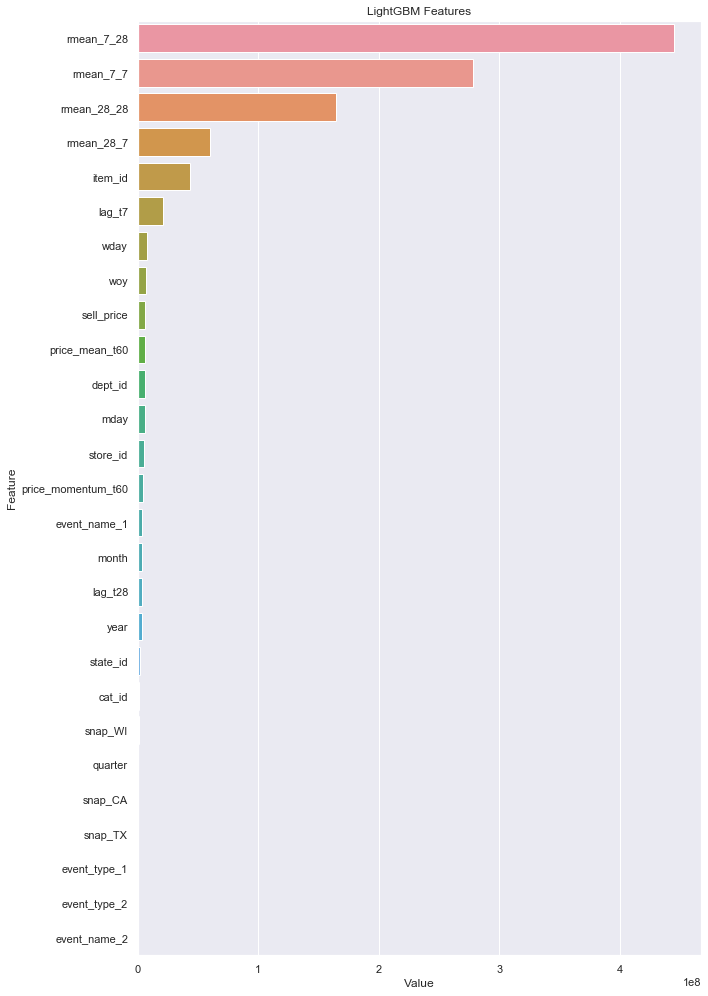

In [21]:
feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance("gain"), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

# Change size of the plot, so we can see all features
fig_dims = (10, 14)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x="Value", y="Feature", ax=ax, data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [22]:
# Detection of features with zero-importance
zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
print(zero_features)
feature_importance


There are 0 features with 0.0 importance
[]


,Value,Feature
20,4.452124e+08,rmean_7_28
18,2.783020e+08,rmean_7_7
21,1.644903e+08,rmean_28_28
19,6.005077e+07,rmean_28_7
0,4.365716e+07,item_id
16,2.092624e+07,lag_t7
5,7.887301e+06,wday
24,6.881390e+06,woy
15,5.947924e+06,sell_price
22,5.910226e+06,price_mean_t60


In [23]:
%%time 

tdata = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_test_model2.pkl')

CPU times: user 207 ms, sys: 152 ms, total: 359 ms
Wall time: 459 ms


In [24]:
def create_lag_features_for_test(df, day):
    # create lag feaures just for single day (faster)
    lags = [7, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df.loc[df.date == day, lag_col] = df.loc[df.date ==day-timedelta(days=lag), 'sales'].values  # !!! main
        
    wins = [7, 28]
    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            df_win = df[(df.date <= day-timedelta(days=lag)) & (df.date > day-timedelta(days=lag+win))]
            df_win_grouped_mean = df_win.groupby("id").agg({'sales':'mean'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rmean_{lag}_{win}"] = df_win_grouped_mean.sales.values            

    return df
    
    
## Creating features for test data
def create_static_features_for_test(df):
    # We create lags here, so we can use them later 
    # for weighted moving average computations
    lags = [7, 28]
    lag_cols = [f"lag_t{lag}" for lag in lags ]

    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)
    
    # copy of the code from `create_df()` above
    date_features = {
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(
                df["date"].dt, date_feat_func).astype("int16")
            
    # Create price features
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    
    # Add mean encoding features
#     global mean_encodings_df
#     df = df.merge(mean_encodings_df, on=['id'])

    return df


In [31]:
tdata = create_static_features_for_test(tdata)

In [32]:
%%time

for i in range(0, 28):
    day = FIRST_PRED_DAY + timedelta(days=i)
    print(i, day)
    tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
    tst = create_lag_features_for_test(tst, day)
    tst = tst.loc[tst.date == day, train_cols]
    # Check that all features generated correctly
    if tst[tst.isna().any(axis=1)].shape[0] > 0:
        print('Some values in tst are nans:')
        print(tst[tst.isna().any(axis=1)])
    tdata.loc[tdata.date == day, "sales"] = 1.03 * m_lgb.predict(tst.values.astype(np.float16)) 


0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
CPU times: user 32min 7s, sys: 7.9 s, total: 32min 15s
Wall time: 8min 53s


In [33]:
os.system('say "Prediction complete"')

0

In [34]:
tdata.loc[(tdata.date >= FIRST_PRED_DAY) & (tdata.sales > 2)].count()

id                    143373
item_id               143373
dept_id               143373
store_id              143373
cat_id                143373
state_id              143373
d                     143373
sales                 143373
date                  143373
wm_yr_wk              143373
weekday               143373
wday                  143373
month                 143373
year                  143373
event_name_1          143373
event_type_1          143373
event_name_2          143373
event_type_2          143373
snap_CA               143373
snap_TX               143373
snap_WI               143373
sell_price            143373
lag_t7                143373
lag_t28               143373
woy                   143373
quarter               143373
mday                  143373
price_mean_t60        143373
price_momentum_t60    143373
dtype: int64

In [35]:
%%time

tdata_sub = tdata.loc[tdata.date >= FIRST_PRED_DAY, ["id", "sales"]].copy()
tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+ timedelta(days=h), "id"] = tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+timedelta(days=h), 
                                                                     "id"].str.replace("validation$", "evaluation")
tdata_sub["F"] = [f"F{rank}" for rank in tdata_sub.groupby("id")["id"].cumcount()+1]
tdata_sub = tdata_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
tdata_sub.fillna(0., inplace = True)

# # kyakovlev magic trick
# for i in range(1,29):
#     tdata_sub['F'+str(i)] *= 1.02

tdata_sub.to_csv(f"{DATA_OUTPUT_DIR}/submission_1.csv",index=False)
tdata_sub.shape


CPU times: user 3.83 s, sys: 307 ms, total: 4.13 s
Wall time: 4.5 s


(60980, 29)

In [36]:
tst

,item_id,dept_id,store_id,cat_id,state_id,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,price_mean_t60,price_momentum_t60,woy,quarter,mday
3871936,0,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,8.382812,1.091797,1.0,0.910645,1.142578,0.967773,0.964355,8.351562,1.003906,20,2,22
3871943,1,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.970703,0.270264,0.0,0.208496,0.142822,0.198853,0.071411,3.970703,1.000000,20,2,22
3871950,2,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.970703,0.646973,1.0,0.461426,0.856934,0.568848,0.571289,2.970703,1.000000,20,2,22
3871957,3,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,4.640625,3.257812,2.0,2.062500,2.572266,2.154297,1.821289,4.640625,1.000000,20,2,22
3871964,4,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.880859,1.477539,4.0,1.161133,1.713867,1.278320,1.357422,2.880859,1.000000,20,2,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4085331,3044,6,9,2,2,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.980469,0.604004,1.0,0.441895,0.285645,0.359375,0.214233,2.980469,1.000000,20,2,22
4085338,3045,6,9,2,2,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.480469,0.591797,0.0,0.454834,0.142822,0.328125,0.321533,2.408203,1.030273,20,2,22
4085345,3046,6,9,2,2,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.980469,1.618164,0.0,1.219727,0.571289,0.895020,0.893066,3.980469,1.000000,20,2,22
4085352,3047,6,9,2,2,2,5,2016,0,0,0,0,0.0,0.0,0.0,1.280273,1.437500,3.0,1.176758,1.142578,1.147461,0.928711,1.280273,1.000000,20,2,22
